<a href="https://colab.research.google.com/github/LauJohansson/DeepLearning_NLP_Friends/blob/master/NLP_The_One_with_Friends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction**

We build a Recurrent Neural Network (RNN) using the Long Short-Term Memory (LSTM) architecture. Through tuning of hyperparameters and regularization through variational sequence length and DropConnect we achieve a perplexity value on the Penn Treebank dataset. We then utilize the found model to generate dialogue for the TV-series “Friends”. To this end, we pretrain the model on Wikipedia text and further tune the hyperparameters to fit “Friends”. Finally, we show a subset of the predicted dialogue and visualise the found semantics of “Friends” through t-SNE on the embedding weights.  




NB: When opening from Github you can not load or save pretrained model

##Acknowledgements


This notebook is inspired by the following NLP Tutorial:https://github.com/graykode/nlp-tutorial
Made by Tae-Hwan Jung. 

# **Initialising Friends data**


![alt text](https://drive.google.com/uc?id=1JzPdBavHFL-8R1Tc0F6z9KlELR326MXy)


In [129]:
#Imports
import collections
import pickle
import pandas as pd
import glob
import io
import matplotlib. pyplot as plt
from collections import Counter
# Importing drive method from colab for accessing google drive
from google.colab import drive

# Mounting drive
## This will require authentication : Follow the steps as guided

##Choose your path for saving and loading the trained net:

##Default path:
#PATH="/content/drive/My Drive/"

#Authors path:
PATH="/content/drive/My Drive/DL_project/"

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
#Loading data from Github
## If your are one of the authors or you have the files located on your google drive - google drive is used. 

#Choose target corpus (Penn Tree Bank or Friends)

#Friends
TargetPath="friends_"

#PennTreeBank
#TargetPath="ptb."


#Choose training corpus (Seinfeld or Wikipedia)

#Seinfield
TrainPath="seinfeld"

#Wiki
#TrainPath="wiki"


try: #If files in google drive
  datafrom='Drive'
  target_train = open(PATH+TargetPath+"train.txt").read()
  target_valid = open(PATH+TargetPath+"valid.txt").read()
  target_test = open(PATH+TargetPath+"test.txt").read()

  pretraining_train = open(PATH+TrainPath+"trainclean.txt").read()
  pretraining_valid = open(PATH+TrainPath+"validclean.txt").read()
  pretraining_test = open(PATH+TrainPath+"testclean.txt").read()
  
except: #For github version
  datafrom='Github'
  from urllib.request import urlopen

  target_train=str(urlopen('https://raw.githubusercontent.com/LauJohansson/DeepLearning_NLP_Friends/master/Data/'+TargetPath+'train.txt').read(),encoding="utf-8")
  target_valid = str(urlopen('https://raw.githubusercontent.com/LauJohansson/DeepLearning_NLP_Friends/master/Data/'+TargetPath+'valid.txt').read(),encoding="utf-8")
  target_test = str(urlopen('https://raw.githubusercontent.com/LauJohansson/DeepLearning_NLP_Friends/master/Data/'+TargetPath+'test.txt').read(),encoding="utf-8")

  pretraining_train = str(urlopen('https://raw.githubusercontent.com/LauJohansson/DeepLearning_NLP_Friends/master/Data/'+TrainPath + 'trainclean.txt').read(),encoding="utf-8")
  pretraining_valid = str(urlopen('https://raw.githubusercontent.com/LauJohansson/DeepLearning_NLP_Friends/master/Data/'+TrainPath + 'validclean.txt').read(),encoding="utf-8")
  pretraining_test = str(urlopen('https://raw.githubusercontent.com/LauJohansson/DeepLearning_NLP_Friends/master/Data/'+TrainPath + 'testclean.txt').read(),encoding="utf-8")


In [131]:
#Check where you get data from:
datafrom

'Drive'

In [132]:
# check data
print("Traindata snippet target:    " + target_train[:100])
print("Validdata snippet target:    " + target_valid[:100])
print("Testdata snippet target:     " + target_test[:100])
print()
print("Traindata snippet pretraining:       " + pretraining_train[:100])
print("Validdata snippet pretraining:       " + pretraining_valid[:100])
print("Testdata snippet pretraining:        " + pretraining_test[:100])

Traindata snippet target:    [ scene: central perk , chandler , joey , phoebe , and monica are there . ] monica: there's nothing 
Validdata snippet target:    parts that i really wanted . you always believed in me man . even , even when i didn't believe in my
Testdata snippet target:     is at the half - opened door ] phoebe: ( in a strange heavy accent ) hello <unk> , it's time for you

Traindata snippet pretraining:       int . comedy club \u2013 night ( jerry is on stage , performing . ) jerry: do you know what this is 
Validdata snippet pretraining:       : sounds like a nice girl . hey jerry , is it all right if i put some stuff in your fridge ? 'cause 
Testdata snippet pretraining:        stack of mail out at the desk that belongs to you . now , you want that mail , don't you mr . kramer


In [133]:
# Find words that occur in friends data, but not in pretraining data
words_notinpretraining = list(set(target_train.split()).difference(pretraining_train.split()))
words_notinpretraining[0:5]

['extract', 'erin', 'craps', 'back...', 'porsche']

# **Initialising Penn Tree Bank data**
![alt text](https://drive.google.com/uc?id=1A8SY9dmsLx2hoanWWWhT_IJnJcJOmluR)


#***Import and initializing hyperparameters***


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from collections import Counter
import os
from argparse import Namespace

flags = Namespace(
    mode = 'target', #'pretraining' is pretraining and 'target' is fine-tuning of either PTB data or friends data. 
    name='Friends',
    train_file_pretraining = pretraining_train,                    
    valid_file_pretraining = pretraining_valid, 
    test_file_pretraining = pretraining_test,   
    train_file_target= target_train,                    
    valid_file_target= target_valid, 
    test_file_target = target_test,
    seq_size= 32,                        #Sequence Length
    batch_size=40,                       #Batch size
    embedding_size=256,                  #Embedding size
    lstm_size=512,                       #Hidden nodes size
    gradients_norm=0.5,   
    #initial_words=['banknote', 'berlitz'],
    initial_words_train = [],
    initial_words_valid= [],
    predict_top_k=5,                    #Choose the k best next_word_prediction, and a random is chosing.
    checkpoint_path='checkpoint',
    total_epochs=100,                   #Choose number of epochs in training
    learning_rate=0.001,                #Choose number of epochs in training
    predict_every=1000,
    #validation_corpus_size=len(valid_file.split()),
    dropconnect_rate=0.4,               #Choose drop connect rate
    n_lay=2,                            #Choose number of LSTM layers

    #Set variational sequence length on/off
    var_seq='Y',                            #Choose if variational sequence length is on/off
    var_seq_std=2,                          #Choose std. dev. for norm distribution for var. seq. length ( in moment 1/2 of seq length)


    #scheduler parameters
    schedule_on='N',                        #Choose if LR-scheduler is on/off
    triangular='N',                         #Choose 'Y' to turn on the slanted triangular LR. 
    cut_fracI=0.2,                          #Choose the fraction of iterations we increase the LR in STL
    ratioI=32,                              #Choose how much smaller the lowest LR is from the maximum LR ηmax
    nmaxI=0.0,                              #this will be set = learning_rate 

    #Use same drop-mask for drop-connect
    same_drop_lstm='N',                     #Choose 'Y' if drop-connect all should use same mask
    
    #Dropout on embedding layer
    drop_embed=0.5,                         #Choose dropoutrate for embedding dropout        

    #Optimizer selection
    optim_select='AdamW'                      #Choose between "AdamW, SGD, ASGD"

)


#initialising two random words, the train and test data should use
if flags.mode == 'target':
  for i in range(0,1):
    flags.initial_words_train.append(np.random.choice(flags.train_file_target.split()))
    flags.initial_words_valid.append(np.random.choice(flags.valid_file_target.split()))
    flags.validation_corpus_size = len(flags.valid_file_target.split())
    
if flags.mode == 'pretraining':
  for i in range(0,1):
    flags.initial_words_train.append(np.random.choice(flags.train_file_pretraining.split()))
    flags.initial_words_valid.append(np.random.choice(flags.valid_file_pretraining.split()))
    flags.validation_corpus_size = len(flags.valid_file_pretraining.split())

#Setting nmaxI in the schedulers
flags.nmaxI=flags.learning_rate

#**Define functions and set up model**

##Function to get data for main and batch-function

In [0]:
def get_data_from_file(train_file, batch_size, seq_size):
  
    text=train_file.split()
    # Extend words_notinpretraining to text to get them as a part of the mapping dictionary
    text.extend(words_notinpretraining)
    word_counts = Counter(text)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    n_vocab = len(int_to_vocab)

    text=train_file.split()

    print('Vocabulary size', n_vocab)

    int_text = [vocab_to_int[w] for w in text]
    num_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:num_batches * batch_size * seq_size]
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:]
    out_text[-1] = in_text[0]
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))
    return int_to_vocab, vocab_to_int, n_vocab, in_text, out_text

In [0]:
def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]

##Setting up the model

In [0]:
class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm=nn.LSTM(embedding_size,
                            lstm_size,
                            batch_first=True,num_layers=flags.n_lay)
        
        self.dense = nn.Linear(lstm_size, n_vocab)
        self.drop_out=nn.Dropout(flags.drop_embed)
        self.OneMaskOnly=torch.autograd.Variable(torch.Tensor(getattr(self.lstm,self.lstm._all_weights[0][0]).shape[0],
                                                        getattr(self.lstm,self.lstm._all_weights[0][0]).shape[1]).uniform_().to("cuda") > flags.dropconnect_rate)


    def forward(self, x, prev_state):
        embed = self.embedding(x)
        embed=self.drop_out(embed)
        orig=[]

        #Make dropconnect
        if self.training:
          for i in range( len(self.lstm._all_weights[0])):
            name = self.lstm._all_weights[0][i]
            if name.find('LSTM.weight_hh_l')!=-1:      
              orig.append(getattr(self.lstm,name))
            
              if flags.same_drop_lstm=='Y':
                mask=self.OneMaskOnly
              else:
                mask=torch.autograd.Variable(torch.Tensor(getattr(self.lstm,name).shape[0],
                                                        getattr(self.lstm,name).shape[1]).uniform_().to("cuda") > flags.flags.dropconnect_rate)
              setattr(self.lstm,name,torch.nn.Parameter(torch.mul(getattr(self.lstm,name),mask)))
              
              self.lstm.flatten_parameters()
             

        #LSTM forward
        output, state = self.lstm(embed, prev_state)

        #Set hh-weight back to original
        if self.training:
          a=0
          for i in range( len(self.lstm._all_weights[0])):
            name = self.lstm._all_weights[0][i]
            if name.find('LSTM.weight_hh_l')!=-1:
              print(orig)
              setattr(self.lstm,name,orig[a])
              #self.lstm.weight_hh_l0=orig
              self.lstm.flatten_parameters()
              a=+1

        logits = self.dense(output)

        return logits, state
       
    def zero_state(self, batch_size):
        return (torch.zeros(flags.n_lay, batch_size, self.lstm_size),
                torch.zeros(flags.n_lay, batch_size, self.lstm_size))

##Defining ASGD
from: https://pytorch.org/docs/stable/_modules/torch/optim/asgd.html


In [0]:
#import torch
#from .optimizer import Optimizer


class ASGD(torch.optim.Optimizer):
    """Implements Averaged Stochastic Gradient Descent.

    It has been proposed in `Acceleration of stochastic approximation by
    averaging`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-2)
        lambd (float, optional): decay term (default: 1e-4)
        alpha (float, optional): power for eta update (default: 0.75)
        t0 (float, optional): point at which to start averaging (default: 1e6)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)

    .. _Acceleration of stochastic approximation by averaging:
        http://dl.acm.org/citation.cfm?id=131098
    """

    def __init__(self, params, lr=1e-2, lambd=1e-4, alpha=0.75, t0=1e6, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, lambd=lambd, alpha=alpha, t0=t0,
                        weight_decay=weight_decay)
        super(ASGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('ASGD does not support sparse gradients')
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['eta'] = group['lr']
                    state['mu'] = 1
                    state['ax'] = torch.zeros_like(p.data)

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # decay term
                p.data.mul_(1 - group['lambd'] * state['eta'])

                # update parameter
                p.data.add_(-state['eta'], grad)

                # averaging
                if state['mu'] != 1:
                    state['ax'].add_(p.data.sub(state['ax']).mul(state['mu']))
                else:
                    state['ax'].copy_(p.data)

                # update eta and mu
                state['eta'] = (group['lr'] /
                                math.pow((1 + group['lambd'] * group['lr'] * state['step']), group['alpha']))
                state['mu'] = 1 / max(1, state['step'] - group['t0'])

        return loss

##Define function to call optimizer

In [0]:
def get_loss_and_train_op(net, lrI):
    criterion = nn.CrossEntropyLoss()
    if (flags.optim_select=='ASGD'):
      optimizer = torch.optim.ASGD(net.parameters(), lr=lrI,weight_decay=0,t0=0,lambd=0) #decay, t0 and lambd taken from article
    elif (flags.optim_select=='SGD'):
      optimizer = torch.optim.SGD(net.parameters(), lr=lrI) #decay, t0 and lambd taken from article
    else:  
      optimizer = torch.optim.AdamW(net.parameters(), lr=lrI,weight_decay=0.3)
  
    return criterion, optimizer

##Define function to schedule optimizer for ASGD


Article used: [Universal Language Model Fine-tuning for Text Classification](https://www.aclweb.org/anthology/P18-1031.pdf?fbclid=IwAR0-TADs3LWh74b4xbA2QW5OYM5-_5iFu2EBjd_0-KVWOUytnBV5TeS9KGo)

In [0]:
#T=number of epochs * number of updates per epoch
#"cut_frac" is the fraction of iterations we increase the LR
# "cut" is the iteration when we switch from increasing to decreasing the LR
# "p" is the fraction of the number of iterations we have increased or will decrease the LR respectively
# "ratio" specifies how much smaller the lowest LR is from the maximum LR nmax
#"nt"/return value is the learning rate at iteration t.

#The paper generally use cut_frac = 0.1, ratio = 32 and ηmax = 0.01


def triangular_lr_func(t,T,cut_frac=flags.cut_fracI, ratio=flags.ratioI, nmax=flags.nmaxI ):
    cut=np.floor(T*cut_frac)

    if (t<cut): p=t/cut
    else: p=1-((t-cut)/(cut*(ratio-1)))


    return nmax * (1+p*(ratio-1))/ratio

##Custommade scheduler
This scheduler is an example on how ASGD LR can be decreased for each iteration. 

In [0]:
def easy_schedule(t,nmax=flags.nmaxI):
  result = nmax-(t*0.0001)

  if(result<0.1): result=0.1

  return result


#**Define main**

In [0]:
def main():  
    torch.manual_seed(11)
    print('------------------------------------------------------------------------  ')
    print('----------------------Go into training mode--------------------------------  ')
    print("----------------------using %s data------------------------" % flags.mode)
    print('------------------------------------------------------------------------  ')
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Pre-training mode on pretrainingtext
    # Start network from scratch
    if flags.mode == 'pretraining': 
      int_to_vocab, vocab_to_int, n_vocab, in_text, out_text = get_data_from_file(
          flags.train_file_pretraining, flags.batch_size, flags.seq_size)
           
    # Fine-tuning mode on target (friends)
    if flags.mode == 'target': 

      # Get int_to_vocab, vocab_to_int, n_vocab from pretraining text pre-training
      int_to_vocab, vocab_to_int, n_vocab, _, _ = get_data_from_file( 
          flags.train_file_pretraining, flags.batch_size, flags.seq_size)
      

      # Load and store data for friends-training
      text = flags.train_file_target.split()
      int_text = [vocab_to_int[v] for v in text]
      var1 = len(int_text) % flags.batch_size 
      in_text =   int_text[:] if var1==0 else  int_text[:-var1]              ## Added -19 to make divisble with 20 batch size
      out_text = np.zeros_like(in_text)
      out_text[:-1] = in_text[1:]
      out_text[-1] = in_text[0]
      in_text = np.reshape(in_text, (flags.batch_size, -1))
      out_text = np.reshape(out_text, (flags.batch_size, -1))


    if flags.mode == 'pretraining': 
      # Load and store data for validation
      valid_text = flags.valid_file_pretraining.split()
      valid_int_text = [vocab_to_int[v] for v in valid_text]
      var2 = len(valid_int_text) % flags.batch_size
      valid_in_text =  valid_int_text[:] if var2==0 else valid_int_text[:-var2] ## Added -19 to make divisble with 20 batch size
      valid_out_text = np.zeros_like(valid_in_text)
      valid_out_text[:-1] = valid_in_text[1:]
      valid_out_text[-1] = valid_in_text[0]
      valid_in_text = np.reshape(valid_in_text, (flags.batch_size, -1))
      valid_out_text = np.reshape(valid_out_text, (flags.batch_size, -1))

      test_text = flags.test_file_pretraining.split()
      test_int_text = [vocab_to_int[v] for v in test_text]
      var3 = len(test_int_text) % flags.batch_size
      test_in_text =  test_int_text[:] if var3==0 else test_int_text[:-var3]
      test_out_text = np.zeros_like(test_in_text)
      test_out_text[:-1] = test_in_text[1:]
      test_out_text[-1] = test_in_text[0]
      test_in_text = np.reshape(test_in_text, (flags.batch_size, -1))
      test_out_text = np.reshape(test_out_text, (flags.batch_size, -1))

    
    if flags.mode == 'target': 
      # Load and store data for validation
      valid_text = flags.valid_file_target.split()
      valid_int_text = [vocab_to_int[v] for v in valid_text]
      var4 = len(valid_int_text) % flags.batch_size
      valid_in_text = valid_int_text[:] if  var4==0 else  valid_int_text[:-var4]
      valid_out_text = np.zeros_like(valid_in_text)
      valid_out_text[:-1] = valid_in_text[1:]
      valid_out_text[-1] = valid_in_text[0]
      valid_in_text = np.reshape(valid_in_text, (flags.batch_size, -1))
      valid_out_text = np.reshape(valid_out_text, (flags.batch_size, -1))

      test_text = flags.test_file_target.split()
      test_int_text = [vocab_to_int[v] for v in test_text]
      var5 = len(test_int_text) % flags.batch_size
      test_in_text = test_int_text[:] if  var5==0 else  test_int_text[:-var5]
      test_out_text = np.zeros_like(test_in_text)
      test_out_text[:-1] = test_in_text[1:]
      test_out_text[-1] = test_in_text[0]
      test_in_text = np.reshape(test_in_text, (flags.batch_size, -1))
      test_out_text = np.reshape(test_out_text, (flags.batch_size, -1))


    if flags.mode == 'pretraining': 
      net = RNNModule(n_vocab, flags.seq_size,
                      flags.embedding_size, flags.lstm_size)
      net = net.to(device)

    if flags.mode == 'target':  
      net = RNNModule(n_vocab, flags.seq_size,
                      flags.embedding_size, flags.lstm_size)
      if datafrom=='Drive':
        net.load_state_dict(torch.load(PATH+'net.pth'))
      else:
        net.load_state_dict(torch.load('/content/drive/My Drive/net.pth'))
      
      net = net.to(device)
      net.eval()

    criterion, optimizer = get_loss_and_train_op(net, flags.learning_rate)


    

    #Documentation from: https://pytorch.org/docs/master/optim.html

    if (flags.schedule_on=='Y'):
      expected_number_of_epochs= (np.prod(in_text.shape) // (flags.seq_size * flags.batch_size))*flags.total_epochs
      
    if (flags.triangular=='Y'):
        lambda1= lambda iteration_schedule: triangular_lr_func(iteration_schedule,expected_number_of_epochs)
    else:
        lambda1= lambda iteration_schedule: easy_schedule(iteration_schedule)


    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    iteration = 0

    if (flags.schedule_on=='Y'):
      iteration_schedule=0

    epochnumber = []
    all_train_losses = []
    all_valid_losses = []
    all_test_losses = []
    for e in range(flags.total_epochs): #Implemented flags.total_epochs to change parameter
        epochnumber.extend([e+1])

        ######################## TRAINING EPOCH ###########################


        ###Variational sequence length###

        if (flags.var_seq=='Y'):
          base_length=np.round(np.random.normal(flags.seq_size, flags.seq_size/flags.var_seq_std)).astype(int)
          if (base_length<2):
            base_length=2
        else:
          base_length=flags.seq_size

        #########################



        batches = get_batches(in_text, out_text, flags.batch_size, base_length)
        valid_batches = get_batches(valid_in_text, valid_out_text, flags.batch_size, base_length)
        test_batches = get_batches(test_in_text, test_out_text, flags.batch_size, base_length)

        state_h, state_c = net.zero_state(flags.batch_size)
        
        # Transfer data to GPU
        state_h = state_h.to(device)
        state_c = state_c.to(device)

        for x, y in batches:
            iteration += 1


            if (flags.schedule_on=='Y'):
              iteration_schedule+=1
            
            # Tell it we are in training mode
            net.train()

            # Reset all gradients
            optimizer.zero_grad()

            # Transfer data to GPU
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss_value = loss.item()        

            # Perform back-propagation
            loss.backward()

            _ = torch.nn.utils.clip_grad_norm_(
                net.parameters(), flags.gradients_norm)
            
            # Update the network's parameters
            optimizer.step()

            #Scheduler step
            if (flags.schedule_on=='Y'):
              scheduler.step()


            if iteration % 100 == 0:
                print('Epoch: {}/{}'.format(e, flags.total_epochs), 
                      'Iteration: {}'.format(iteration),
                      '\t Loss: {}'.format(loss_value))
                      #'\t Perplexity: {}'.format(2**loss_value))
        

        logits, (state_h, state_c) = net(x, (state_h, state_c))
        loss = criterion(logits.transpose(1, 2), y)
        loss_value_final = loss.item()    
        all_train_losses.append(loss_value_final) 
        print('Final training loss {}'.format(loss_value_final)) 
        

        ##################### VALIDATION EPOCH ########################
        iteration = 0

        state_h, state_c = net.zero_state(flags.batch_size)
        # Transfer data to GPU

        state_h = state_h.to(device)
        state_c = state_c.to(device)

        for x, y in valid_batches:

            iteration += 1

            # Tell it we are in evaluation mode
            net.eval()

            # Transfer data to GPU
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            valid_loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            valid_loss_value = valid_loss.item()

        all_valid_losses.append(valid_loss_value)


        ##################### TEST EPOCH ########################
        iteration = 0

        state_h, state_c = net.zero_state(flags.batch_size)
        # Transfer data to GPU

        state_h = state_h.to(device)
        state_c = state_c.to(device)

        for x, y in test_batches:

            iteration += 1

            # Tell it we are in evaluation mode
            net.eval()

            # Transfer data to GPU
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            test_loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            test_loss_value = test_loss.item()

        all_test_losses.append(test_loss_value)


        print('')
       # print('Current mean of validation loss over batches: {}'.format(mean_all_valid_losses))
        print('Current validation loss: {}'.format(valid_loss_value))
        print('Validation perplexity: {}'.format(np.exp((valid_loss_value))))
        print(' ')
        print('Current test loss: {}'.format(test_loss_value))
        print('Test perplexity: {}'.format(np.exp((test_loss_value))))

        print('')
            
        plt.figure(1)                             
        plt.xlabel('Epochs'), plt.ylabel('Loss')   
        plt.plot(epochnumber, all_train_losses, 'r', epochnumber, all_valid_losses, 'b', epochnumber, all_test_losses, 'g')
        plt.legend(['Train Loss','Validation Loss', 'Test Loss'])    
   
        last= predict(device, net, flags.initial_words_train, n_vocab,
                            vocab_to_int, int_to_vocab, flags.predict_top_k)
        print('\nThe last predicted 200 characters are:\n')
        print(last[-200:])

    #path = "/content/drive/My Drive/DL_project/"
    # save the pretrained model if the validation loss is less than minimum validation loss.
        if flags.mode == 'pretraining' and e > 0 and valid_loss_value <= min(all_valid_losses) :
          if ( datafrom=='Drive'):
            torch.save(net.state_dict(), PATH+'net.pth')
            print('Saved model')
          else:
            torch.save(net.state_dict(), '/content/drive/My Drive/net.pth')
            print('Saved model')

        #If target-mode then save the "best" model as "net_final.pth"
        if flags.mode == 'target' and e > 0 and valid_loss_value <= min(all_valid_losses) :
          if ( datafrom=='Drive'):
            torch.save(net.state_dict(), PATH+'net_final.pth')
            print('Saved model')
          else:
            torch.save(net.state_dict(), '/content/drive/My Drive/net_final.pth')
            print('Saved model')


    if (flags.mode=='target'):
      print('-----------------------------------------------------------')
      print('--------------------Making T-SNE plots---------------------')
      print('-----------------------------------------------------------')
  

      embedding_tensor=net.embedding.weight
    
      # access Variable's tensor, copy back to CPU, convert to numpy
      arr = embedding_tensor.data.cpu().numpy()
      # write CSV
      #np.savetxt('Embedded_4.csv', arr)
      #files.download('Embedded_4.csv')

      print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
      print("Running example on Friends Data...")
      #X = np.loadtxt("Embedded_4.csv")
      X = arr
      X = X[0:1000,:] #only the 1040 most used
      #with open('Embedded_labels4.csv', 'rb') as f:
      #    labels = pickle.load(f)
      #labels = labels[0:1000] #only the 1040 most used
      labels = list(int_to_vocab.values())[0:1000] #only the 1040 most used
                
      #labels = np.loadtxt("mnist2500_labels.txt")
      Y = tsne(X, 2, 50, 20.0)
      #pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)  
      #pylab.show()  
      
      # write labels of interest
      subset =['monica','rachel','chandler','ross','joey','phoebe','coffee','gunther','table','muffin','running','drinking','sex','science','movies','beer','pizza','food','janice','guy','girl','wine','paul','barry','it','i','you','he','she','they','ok','love','like','kiss','dinner','lasagna','drink','boy','man','dude','honey','sweetie','hey','hi','hello','muffin','order','place','right','good','fine','so','well']    
      #subset = ['man','boy','woman','girl','drink','drinking','eat','eating','love','loving','where','who','what','why','when']
      a = 1
      labels2 = list()
      X2 =list()
      Y2 =list()
      
      
      for i in range(1,len(labels)):
          if labels[i] in subset:
              labels2.append(labels[i])
              X2.append(Y[:, 0][i])
              Y2.append(Y[:, 1][i])
              
      plt.figure(2)
      #with subset
      for i,type in enumerate(labels2):
          x = X2[i]
          y = Y2[i]
          plt.scatter(x, y, marker='o', color='blue')
          plt.text(x+0.9, y+0.9, type, fontsize=9)
      plt.show()

##Define a prediction function

In [0]:
def predict(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k):
    net.eval()

    state_h, state_c = net.zero_state(1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for w in words:
        ix = torch.tensor([[vocab_to_int[w]]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))
    

    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0]) #A way to avoid always choose like "and" "then"..... 

    words.append(int_to_vocab[choice])

    for _ in range(100):
        ix = torch.tensor([[choice]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    print(' '.join(words))
    return ' '.join(words)

## Importing T-SNE

In [0]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as np
import pylab
import matplotlib.pyplot as plt
import pickle



def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y



#***Run model***

------------------------------------------------------------------------  
----------------------Go into training mode--------------------------------  
----------------------using target data------------------------
------------------------------------------------------------------------  
Vocabulary size 17135
Epoch: 0/100 Iteration: 100 	 Loss: 4.726939678192139
Epoch: 0/100 Iteration: 200 	 Loss: 4.849424839019775
Epoch: 0/100 Iteration: 300 	 Loss: 4.2957892417907715
Epoch: 0/100 Iteration: 400 	 Loss: 4.412343502044678
Epoch: 0/100 Iteration: 500 	 Loss: 4.4628586769104
Epoch: 0/100 Iteration: 600 	 Loss: 4.343562602996826
Epoch: 0/100 Iteration: 700 	 Loss: 4.257201671600342
Epoch: 0/100 Iteration: 800 	 Loss: 4.43337869644165
Epoch: 0/100 Iteration: 900 	 Loss: 4.343355655670166
Epoch: 0/100 Iteration: 1000 	 Loss: 4.214748382568359
Epoch: 0/100 Iteration: 1100 	 Loss: 4.308965682983398
Epoch: 0/100 Iteration: 1200 	 Loss: 4.474051475524902
Epoch: 0/100 Iteration: 1300 	 Loss: 

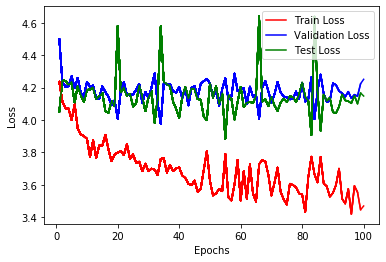

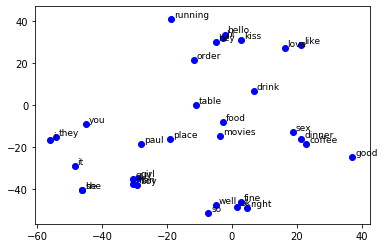

In [145]:
if __name__ == '__main__':
    main()
    